In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
import copy
from EVFleet import * 
import pandas as pd

In [3]:
def create_energy_set(start, M, H, pv, wt):
    days = 365 // M -1
    q = np.zeros((M, H))
    Q = np.zeros((M, days * 24))
    for m in range(M):
        start_idx = m * days * 24
        end_idx = (m + 1) * days * 24
        Q[m, :] = pv[start_idx:end_idx] + wt[start_idx:end_idx]
        q[m, :] = Q[m, start:start+H]

    return q

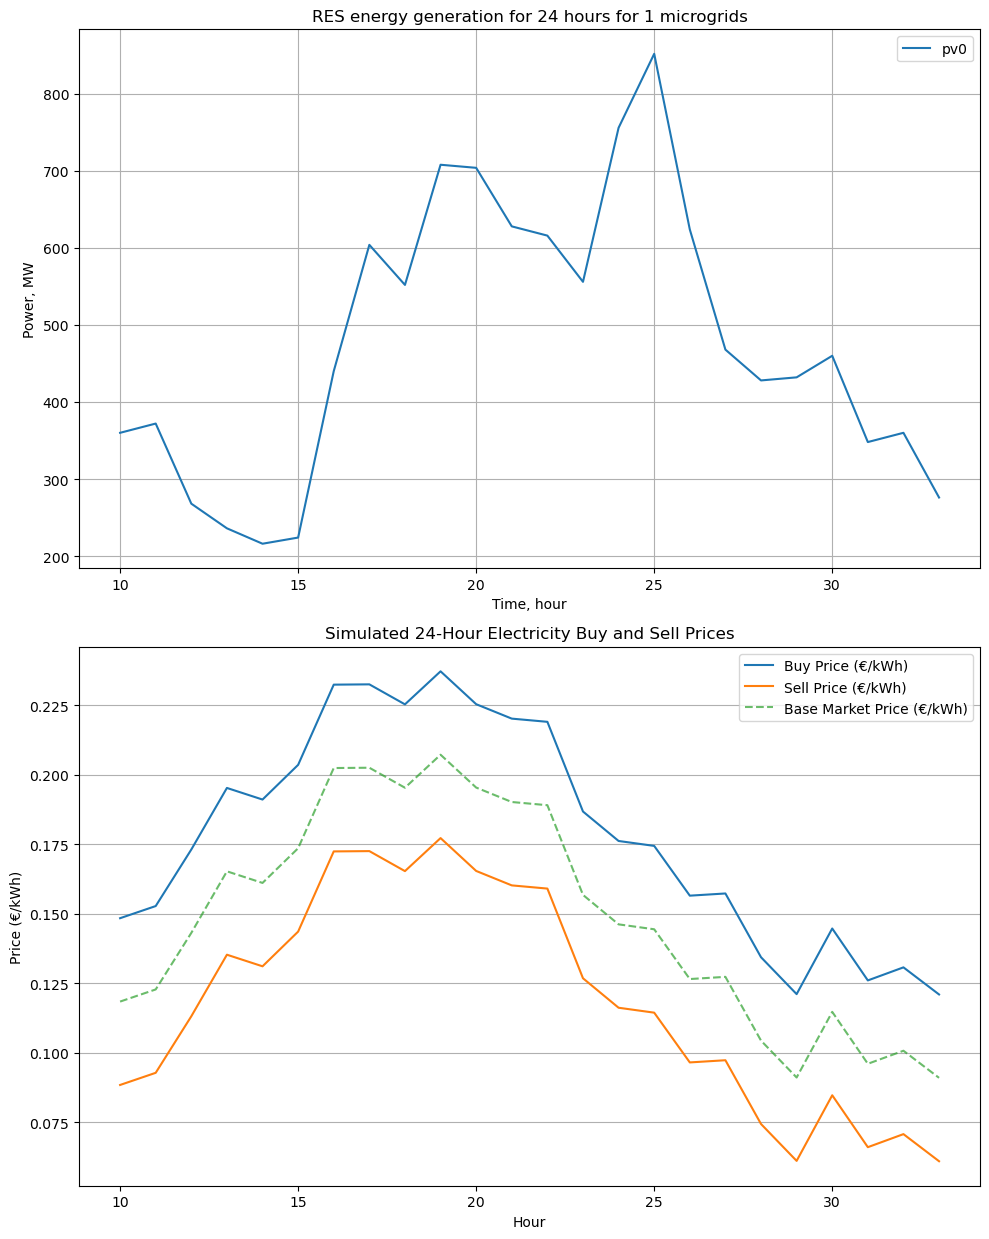

In [91]:
DAYS = 1
H=24
N=1
M=1
start = 10

# Set seed for reproducibility
np.random.seed(42)

hours = np.arange(start, start + H)
base_price = 0.15
amplitude = 0.10

noise = np.random.normal(0, 0.01, size=24*DAYS)
# Symmetric price
prices = base_price + amplitude * (
    np.sin((hours - 8) / 24 * 2 * np.pi) + np.sin((hours - 18) / 24 * 2 * np.pi)
) + noise
prices = np.clip(prices, 0.05, None)
    
# Add asymmetric buy/sell prices
margin = 0.03
c = prices + margin
p = prices - margin
p = np.clip(p, 0.01, None)  # Prevent negative prices

# Load CSV data
pv_energy = '2023_photovoltaic_total_at.csv'  # Replace with your actual file path
wt_energy = '2023_windpower_total_at.csv'  # Replace with your actual file path

pv = pd.read_csv(pv_energy, delimiter=';')
wt = pd.read_csv(wt_energy, delimiter=';')

pv_arr = pv['Power (MW)'].to_numpy()
wt_arr = wt['Power (MW)'].to_numpy()


q = create_energy_set(start, M, H*DAYS, pv_arr, wt_arr)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 12.5))  # 1 row, 2 columns

axs[0].set_title(f'RES energy generation for {H*DAYS} hours for {M} microgrids')
for m in range(M): 
    axs[0].plot(np.arange(start, start+H*DAYS), q[m,:], label=f"pv{m}")
axs[0].legend()
axs[0].set_xlabel('Time, hour')
axs[0].set_ylabel('Power, MW')
axs[0].grid(True)
# First subplot: Buy and Sell Prices
axs[1].plot(hours, c, label='Buy Price (€/kWh)')
axs[1].plot(hours, p, label='Sell Price (€/kWh)')
axs[1].plot(hours, prices, label='Base Market Price (€/kWh)', linestyle='--', alpha=0.7)
axs[1].set_title("Simulated 24-Hour Electricity Buy and Sell Prices")
axs[1].set_xlabel("Hour")
axs[1].set_ylabel("Price (€/kWh)")
axs[1].grid(axis='y')
axs[1].legend()

plt.tight_layout()
plt.savefig("MPC environmental parameters", dpi=300)
plt.show()

In [92]:
fleet = EVFleet(xlsx_path='EV_UsageProfile.xlsx', num_vehicles=N*M)
results = fleet.simulate_multiple_days(num_days=2)

L_usage = np.zeros((M,N,DAYS+1,4), dtype='int')
for row in results:
    L_usage[row['EV'] // 5, row['EV'] % 5, row['Day']-1, 0] = int(row['Initial SoC'])
    L_usage[row['EV'] // 5, row['EV'] % 5, row['Day']-1, 1] = int(row['Goal (kWh)'])
    L_usage[row['EV'] // 5, row['EV'] % 5, row['Day']-1, 2] = int(row['Arrival (h)'])
    L_usage[row['EV'] // 5, row['EV'] % 5, row['Day']-1, 3] = int(row['Departure (h)']) + 24 if int(row['Departure (h)']) + 24 < 34 else 33

    print(row['EV'] // 5, row['EV'] % 5, L_usage[row['EV'] // 5, row['EV'] % 5, row['Day']-1, :])

0 0 [1616 8000   16   30]
0 0 [1054 8000   16   30]


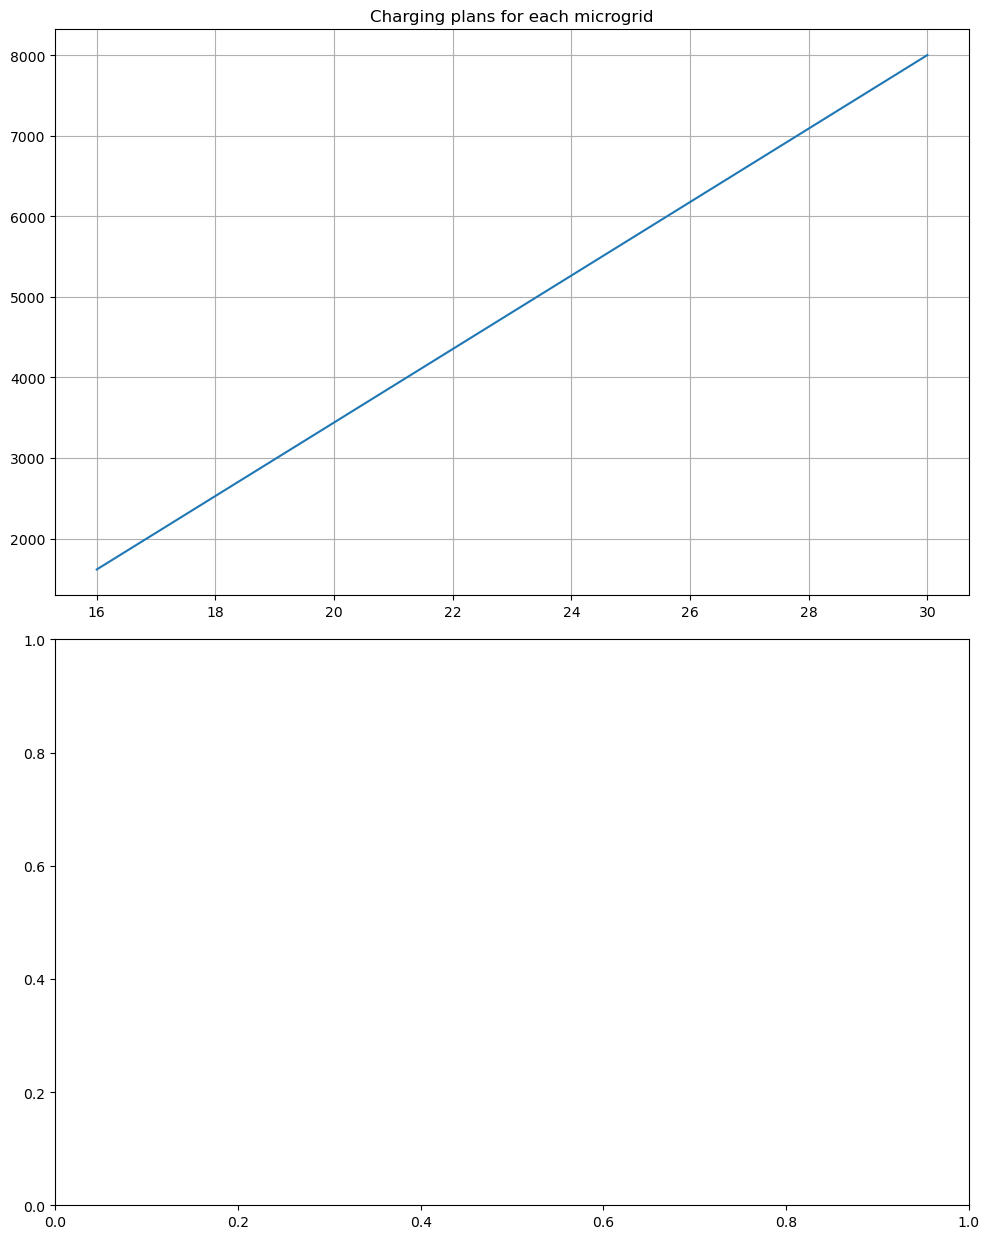

In [93]:
fig, axs = plt.subplots(2, 1, figsize=(10,12.5))
for m in range(M):
    for n in range(N):
        L_init, L_target, L_arrival, L_dep = L_usage[m,n,0,:]
        y = [L_init, L_target]
        x = [L_arrival, L_dep]
        axs[m].plot(x,y)
        axs[m].grid(True)
axs[0].set_title("Charging plans for each microgrid");
plt.tight_layout()
plt.savefig("Charging plans for each microgrid", dpi=300)
plt.show()

In [97]:
def count_lines_at_x(lines):
    counts = [0]

    for x in range(start, start + H):
        N = counts[-1]
        for line in lines:
            y1,y2,x1,x2 = line
            if x == x1:
                N+=1
            if x == x2:
                N-=1
        counts.append(N)
    return counts

In [147]:
def compute_energy_boundaries(H, N, L_init, L_arrival, L_depart, max_charge_step=500, max_capacity=10000):
    max_energy = []
    min_energy = []

    # Current energy of each battery
    energy_levels = [0] * N

    for t in range(H):
        max_total = 0
        min_total = 0
        for i in range(N):
            depart = L_depart[i]
            appear = L_arrival[i]
            if appear <= t <= depart:
                # Battery is active
                time_active = t - appear
                max_energy_i = min(max_capacity, L_init[i] + max_charge_step * time_active)
                min_energy_i = max(0, L_init[i] - max_charge_step * time_active)
            else:
                # Battery is inactive
                max_energy_i = 0
                min_energy_i = 0

            max_total += max_energy_i
            min_total += min_energy_i

        max_energy.append(max_total)
        min_energy.append(min_total)

    return max_energy, min_energy

In [149]:
e_max = np.zeros((M,H))
e_min = np.zeros((M,H))
L_target = L_usage[:,:,0,1]
L_init = L_usage[:,:,0,0]
L_arrival = L_usage[:,:,0,2]
L_depart = L_usage[:,:,0,3]
for m in range(M):
    e_max[m,:], e_min[m,:] = compute_energy_boundaries(H, N, L_init[m], L_arrival[m]-start, L_depart=L_depart[m]-start)
e_max += q

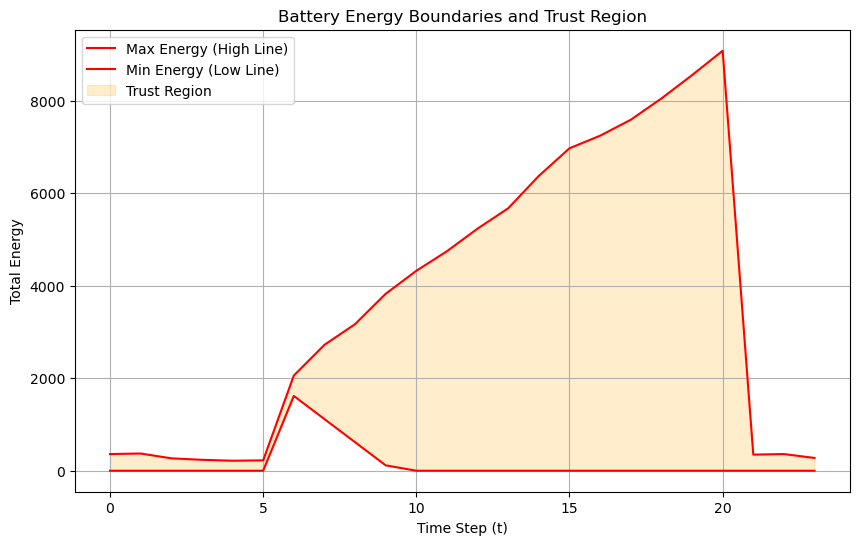

In [151]:
time_steps = np.arange(H)  # Include t=0 to t=H
    
plt.figure(figsize=(10, 6))
    
# Plot high and low lines
plt.plot(time_steps, e_max[0], label='Max Energy (High Line)', color='red')
plt.plot(time_steps, e_min[0], label='Min Energy (Low Line)', color='red')
    
# Fill between the lines (trust region)
plt.fill_between(time_steps, e_min[0], e_max[0], color='orange', alpha=0.2, label='Trust Region')
    
# Labels and title
plt.xlabel('Time Step (t)')
plt.ylabel('Total Energy')
plt.title('Battery Energy Boundaries and Trust Region')
plt.legend()
plt.savefig("Energy trust region", dpi=300)
plt.grid(True)
plt.show()


In [153]:
L_depart_new = []
L_target_new = []

for m in range(M):
    unique_L_depart, inverse_indices = np.unique(L_depart[m], return_inverse=True)

    # Create array to store summed targets
    L_new = np.zeros_like(unique_L_depart, dtype=L_target[m].dtype)

    # Accumulate values into L_new
    np.add.at(L_new, inverse_indices, L_target[m])

    # Append results to lists
    L_depart_new.append(unique_L_depart)
    L_target_new.append(L_new)

print(L_depart_new[0] - start)
print(L_target_new)

[20]
[array([8000])]


In [161]:
# Parameters
c1 = 1
c2 = 1
np.random.seed(42)

Num = np.array([count_lines_at_x(L_usage[m,:,0,:]) for m in range(M)])

d_min = np.zeros((M, H))
d_max = np.ones((M, H)) * 10000

f_min = np.zeros((M, H))
f_max = np.ones((M, H)) * 10000

# Decision variables for each agent
x = [cp.Variable(3*H) for _ in range(M)]

constraints = []
objective = 0
cost_terms = []
target_terms = []

for m in range(M):
    d = x[m][:H]
    f = x[m][H:2*H]
    E = x[m][2*H:]
    
    constraints += [
        d >= d_min[m],
        d <= d_max[m],
        f >= f_min[m],
        f <= f_max[m],
        E >= e_min[m],
        E <= e_max[m]
    ]
    constraints += [
        E[0] ==q[m][0]+ d[0] - f[0]
    ]

    for h in range(1, H):
        constraints += [
            E[h] == E[h-1]+ q[m][h] + d[h] - f[h]
            cp.abs(f[h-1] - f[h]) <= 1000,
            cp.abs(d[h-1] - d[h]) <= 1000
        ]

    energy_cost = cp.sum(cp.multiply(c, d) / q[m] - cp.multiply(p, f) / q[m])
    expected_load = L_target_new[m]
    remaining_energy = cp.hstack([E[depart_time-start] for depart_time in L_depart_new[m]])
    
    energy_target =  cp.sum_squares(expected_load - remaining_energy)
    objective += c1 * energy_cost + c2 *energy_target
    cost_terms.append(energy_cost)
    target_terms.append(energy_target)

# Solve the problem
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve(solver="SCS")


# Collect data for plotting
d_history = np.array([x[m][:H].value for m in range(M)])
f_history = np.array([x[m][H:2*H].value for m in range(M)])
E_history = np.array([x[m][2*H:].value for m in range(M)])
for m in range(M):
    print(f"Objective functions in Agent {m}: "
          f"Cost term: {cost_terms[m].value:.2f}, "
          f"Target term: {target_terms[m].value:.2f}, "
          f"overall objective: {cost_terms[m].value + target_terms[m].value:.2f}")

Objective functions in Agent 0: Cost term: -2.74, Target term: 0.00, overall objective: -2.74


7999.999990396053


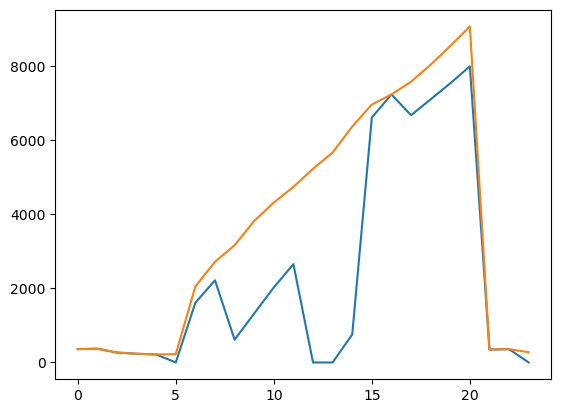

In [163]:
plt.plot(E_history[0])
plt.plot(e_max[0])
print(E_history[0][20])

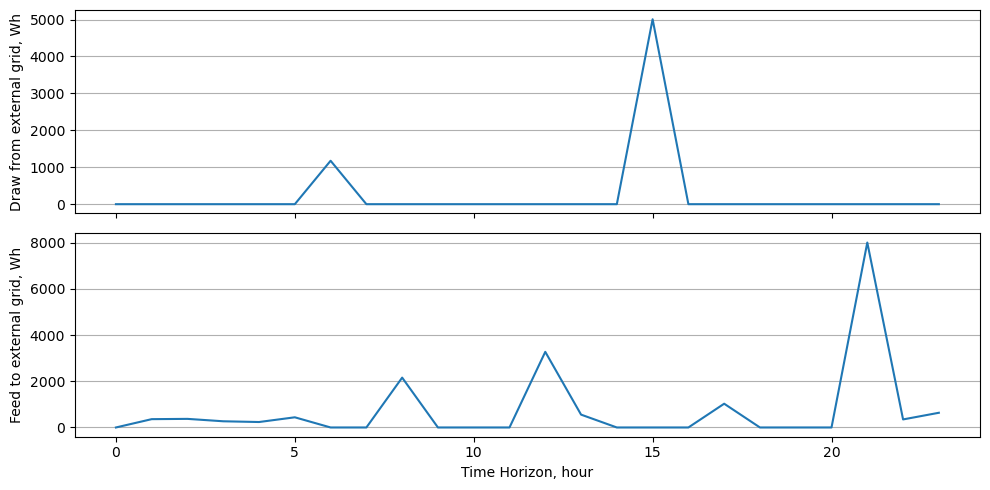

In [165]:
# Plotting
fig, axes = plt.subplots(2, 1, figsize=(10, 2*2.5), sharex=True)

for m in range(M):
    axes[0].plot(d_history[m])
    axes[0].grid(axis='y')
    axes[0].set_ylabel("Draw from external grid, Wh")

for m in range(M):
    axes[1].plot(f_history[m])
    axes[1].grid(axis='y')
    axes[1].set_ylabel("Feed to external grid, Wh")
    
axes[-1].set_xlabel('Time Horizon, hour')
plt.tight_layout()
plt.savefig("Decentralised high-layer framework with data", dpi=300)
plt.show()

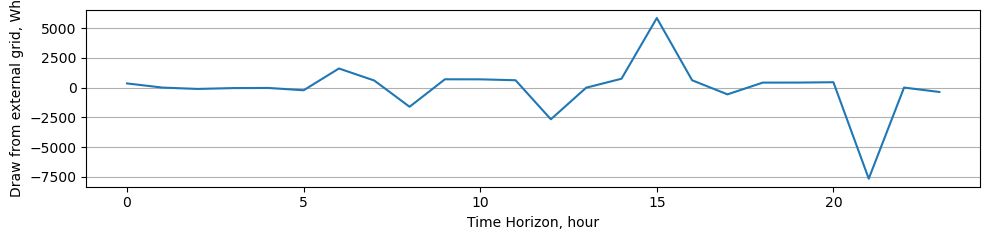

In [167]:
# Plotting
plt.figure(figsize=(10,2.5))

for m in range(M):
    plt.plot(q[m] + d_history[m] - f_history[m])
    plt.grid(axis='y')
    plt.ylabel("Draw from external grid, Wh")
 
plt.xlabel('Time Horizon, hour')
plt.tight_layout()
plt.savefig("Overall energy consumption", dpi=300)
plt.show()

In [175]:
rho = 1.8 #1.8
gamma = 0.1 #0.01, .0005


epsilon = 0.02
c1 = 5
eta = 0.9


# Parameters
L_min = np.ones((M, N, H)) * 500
L_max = np.ones((M, N, H)) * 10000

l_min = np.zeros((M, N, H))
l_max = np.ones((M, N, H)) * 1000

r_min = np.zeros((M, N, H))
r_max = np.ones((M, N, H)) * 1000

# Decision variables for each agent
x = [[cp.Variable(3*H) for _ in range(N)] for _ in range(M)]

lambda_history = []
x_diff_histrory = []


energy_terms = []
penalty_terms = []

# Initial values
x = np.array([[np.zeros(3*H) for _ in range(N)] for _ in range(M)])  # d, f, l, m, L[1:]
lambdas = np.zeros((M,H))

x_prev = copy.deepcopy(x)
iteration = 0

E = q + d_history - f_history


# Collect data for plotting
l_history = np.array([[np.zeros(H) for n in range(N)]for _ in range(M)])
r_history = np.array([[np.zeros(H) for n in range(N)]for _ in range(M)])
L_history = np.array([[np.zeros(H) for n in range(N)]for _ in range(M)])

H_n_T_x = np.zeros((M,N,H))
H_n_T_xi = np.zeros((M,N,H))

while True:
    iteration+=1
    #if iteration % 50 == 0:
        #rho *= 0.9
    for m in range(M):
        for n in range(N):
            constraints = []
            xi = cp.Variable(3*H)
            l = xi[:H]
            r = xi[H:2*H]
            L = xi[2*H:3*H]
            
            constraints += [
                L >= L_min[m][n],
                L <= L_max[m][n],
                l >= l_min[m][n],
                l <= l_max[m][n],
                r >= r_min[m][n],
                r <= r_max[m][n]
            ]
        
            constraints += [
                L[L_arrival[m,n]-start] == L_init[m][n]
            ]

            for h in range(start, start + H):
                if h >= L_depart[m,n]:
                    constraints += [
                        l[h-start] == 0,
                        r[h-start] == 0,
                    ]
                if h <= L_arrival[m,n]:
                    constraints += [
                        l[h-start] == 0,
                        r[h-start] == 0,
                    ]                    
            
            for h in range(1, H):
                constraints += [
                    L[h] == L[h-1] + l[h] - r[h]
                    #cp.abs(l[h-1] - l[h]) <= 1,
                    #cp.abs(r[h-1] - r[h]) <= 1
                ]
            
            penalty_term = cp.sum_squares(L[L_depart[m,n] - start]-L_target[m][n])
            h_n_T_x = l - r
            H_n_T_prev = cp.sum(H_n_T_x[m],axis=0) - H_n_T_x[m][n] - E[m]
            admm_penalty = (rho/2) * cp.sum_squares(h_n_T_x  + H_n_T_prev - 1/rho * lambdas[m])
            admm_update = (9/2) * cp.sum_squares(xi - x_prev[m][n])
    
            objective = cp.Minimize(penalty_term + admm_penalty + admm_update)
            prob = cp.Problem(objective, constraints)
            prob.solve(solver="CLARABEL")
    
            # Save values
            x[m][n] = copy.deepcopy(xi.value)
            H_n_T_xi[m][n] = copy.deepcopy(h_n_T_x.value)
    
            # Collect data for plotting
            l_history[m][n] = copy.deepcopy(l.value)
            r_history[m][n] = copy.deepcopy(r.value)
            L_history[m][n] = copy.deepcopy(L.value)
            g = min(penalty_term.value, admm_penalty.value, admm_update.value)

            #print(f"Penalty:{penalty_term.value//g}, Admm :{admm_penalty.value//g}, update:{admm_update.value//g}")
            """
            print(f"######### Parameters for Agent: {n} ##########")
            print(f"Net cost: {penalty_term.value}")
            print(f"Lambda penalty: {admm_penalty.value}")
            print(f"Update penalty: {admm_update.value}")
            #print(f"Objective value: {objective.value}")
            print(f"############################################")
            print(f" ")
            #"""
    
    H_n_T_x = copy.deepcopy(H_n_T_xi)
    
    lambdas -= gamma * rho * (np.sum(H_n_T_x, axis=1) - E)
    #gamma *=0.9
    print("--------------------------------------------")
    print(f"ITERATION: {iteration}, difference: {np.linalg.norm(x-x_prev)}")
    
    print(f"lambda {np.linalg.norm(np.sum(H_n_T_x,axis=1) - E)}")
    print("--------------------------------------------")
    print(f" ")

    if np.linalg.norm(x-x_prev) <= epsilon and np.linalg.norm(np.sum(H_n_T_x,axis=1) - E) < 0.8:
            break
        
    lambda_history.append(np.linalg.norm(np.sum(H_n_T_x,axis=1) - E))  
    x_diff_histrory.append(np.linalg.norm(x-x_prev))
    x_prev = copy.deepcopy(x)


--------------------------------------------
ITERATION: 1, difference: 4384.347069244438
lambda 10343.294490861412
--------------------------------------------
 
--------------------------------------------
ITERATION: 2, difference: 829.9877194570325
lambda 10021.473360702597
--------------------------------------------
 
--------------------------------------------
ITERATION: 3, difference: 821.3373170767788
lambda 9728.282639847357
--------------------------------------------
 
--------------------------------------------
ITERATION: 4, difference: 491.7158362156648
lambda 9620.27406475002
--------------------------------------------
 
--------------------------------------------
ITERATION: 5, difference: 471.68904491020095
lambda 9539.970585496903
--------------------------------------------
 
--------------------------------------------
ITERATION: 6, difference: 282.8229068418418
lambda 9513.032165929031
--------------------------------------------
 
--------------------------------

KeyboardInterrupt: 

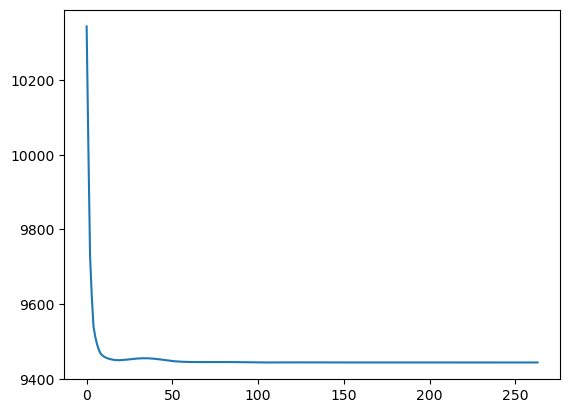

In [177]:
plt.plot(lambda_history)

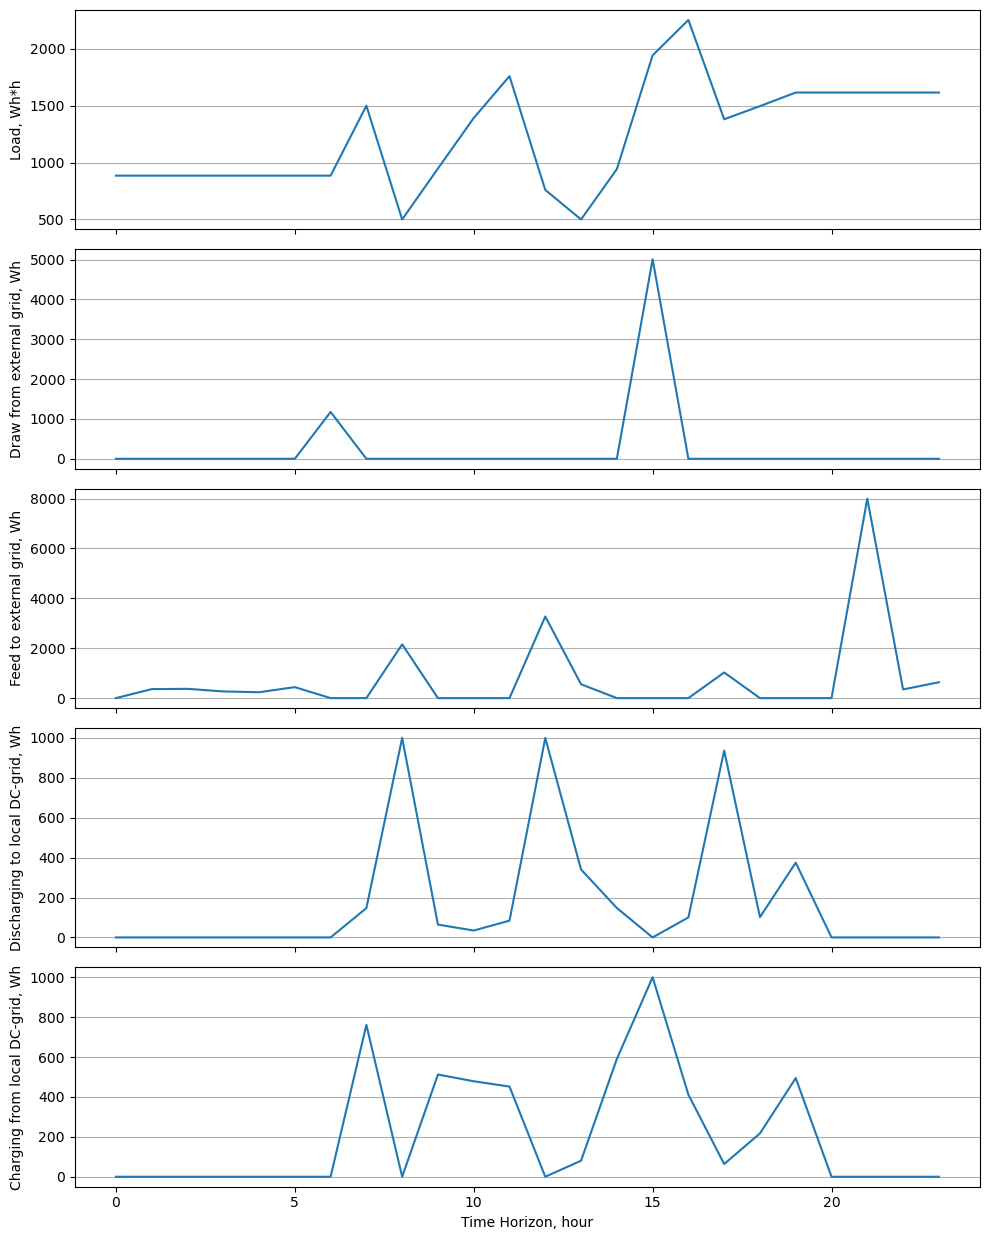

In [179]:
# Plotting
fig, axes = plt.subplots(5, 1, figsize=(10, 5*2.5), sharex=True)
for m in range(1):
    for n in range(N):
        #axes[0].plot(np.full(H,L_target[n]))
        axes[0].plot(L_history[m][n], label =f'agent {n}')
        axes[0].grid(axis='y')
        #axes[0].legend()
        axes[0].set_ylabel("Load, Wh*h")
    

    axes[1].plot(d_history[m])
    axes[1].grid(axis='y')
    axes[1].set_ylabel("Draw from external grid, Wh")
    

    axes[2].plot(f_history[m])
    axes[2].grid(axis='y')
    axes[2].set_ylabel("Feed to external grid, Wh")
        
    for n in range(N):
        axes[3].plot(r_history[m][n])
        axes[3].grid(axis='y')
        axes[3].set_ylabel("Discharging to local DC-grid, Wh")
        
    for n in range(N):
        axes[4].plot(l_history[m][n])
        axes[4].grid(axis='y')
        axes[4].set_ylabel("Charging from local DC-grid, Wh")
    

axes[-1].set_xlabel('Time Horizon, hour')
plt.tight_layout()
plt.savefig("Decentralised multilayer framework", dpi=300)
plt.show()

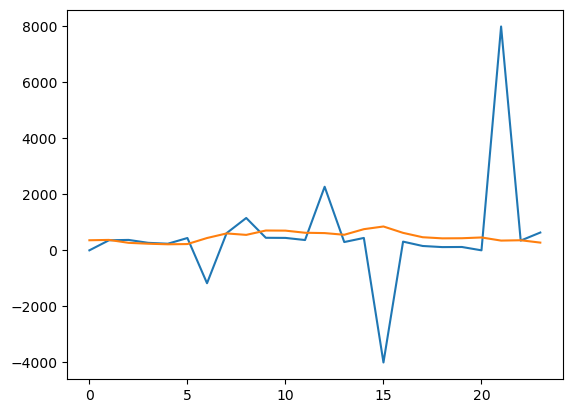

In [185]:
for m in range(1):
    plt.plot(-d_history[m]+f_history[m]+np.sum(l_history[m],axis=0)-np.sum(r_history[m],axis=0))
    #plt.plot(np.sum(l_history[m],axis=0)-np.sum(r_history[m],axis=0))
    plt.plot(q[m])

In [256]:
total_cost = 0
for m in range(M):
    cost = np.sum(c * d_history[m] / q[m] - p * f_history[m] / q[m]) #+ (L_target[m] - L_history[m][:,-1]).T@(L_target[m] - L_history[m][:,-1])
    print(cost)
    total_cost +=cost
print("Average:", total_cost/M)

0.9018895871587571
-1.6269181033826938
-1.038090406641009
Average: -0.5877063076216485


In [258]:
total_cost = 0
for m in range(M):
    for n in range(N):
        total_cost +=100 * (L_target[m][n] - L_history[m][n][-1])/L_target[m][n]
        print(f"Error between target and real load of {1+n} agent is {100 * (L_target[m][n] - L_history[m][n][-1])/L_target[m][n]:.2f}%")
print(f"Average: {total_cost/(M*N)}")

Error between target and real load of 1 agent is 84.75%
Error between target and real load of 2 agent is 76.99%
Error between target and real load of 3 agent is 64.95%
Error between target and real load of 4 agent is 52.95%
Error between target and real load of 5 agent is 75.50%
Error between target and real load of 1 agent is 85.89%
Error between target and real load of 2 agent is 79.64%
Error between target and real load of 3 agent is 78.34%
Error between target and real load of 4 agent is 83.38%
Error between target and real load of 5 agent is 79.71%
Error between target and real load of 1 agent is 75.60%
Error between target and real load of 2 agent is 75.15%
Error between target and real load of 3 agent is 80.34%
Error between target and real load of 4 agent is 83.34%
Error between target and real load of 5 agent is 84.73%
Average: 77.41583334586862


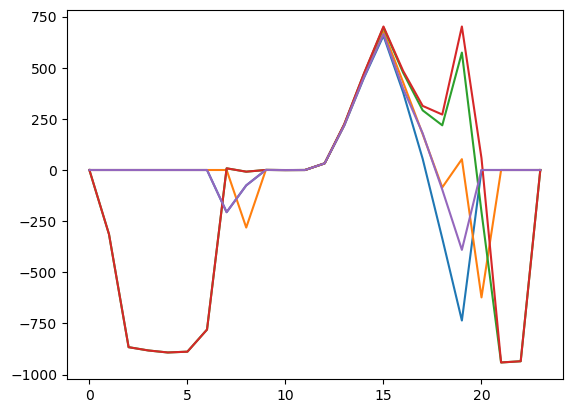

In [260]:
for n in range(N):
    plt.plot(l_history[0][n] - r_history[0][n])